## Importing libraries and packages

In [3]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import math # Needed for pi


## 1. Loading data :
Loading a single image, pose, and camera intrinsics from the Blender ficus dataset.
    

Image Shape: (128, 128, 3)

Camera-to-World Pose Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 4.]
 [0. 0. 0. 1.]]

Calculated Focal Length: 110.85125168440815


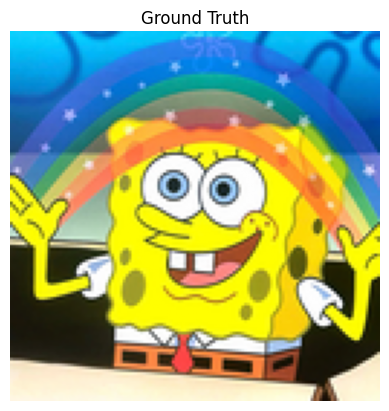

In [4]:
def load_image_with_pose(dataset_dir, img_size=(128, 128)):

    # 1. Define a generic camera field of view (FOV).
    # 60 degrees is a common value. We convert it to radians.
    fov_degrees = 60.0
    camera_angle_x = fov_degrees * (math.pi / 180.0)

    # 2. Define a generic camera-to-world pose matrix.
    # This pose places the camera at (0, 0, 4) and looks towards the origin.
    transform_matrix = [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 4.0],
        [0.0, 0.0, 0.0, 1.0]
    ]

    img = 'imagination.png'

    # 2. Construct the full path to the image file.
    img_path = os.path.join(dataset_dir, img)

    # 3. Load and process the image (same as before).
    image = Image.open(img_path).resize(img_size, Image.LANCZOS)
    image = np.array(image) / 255.0 # Normalize to [0, 1]

    # Extract RGB channels (assumes input is RGBA).
    rgb = image[..., :3]

    # The pose is the camera-to-world transformation matrix.
    pose = np.array(transform_matrix)

    # The focal length is calculated from the camera's horizontal field of view.
    focal = 0.5 * img_size[0] / np.tan(0.5 * camera_angle_x)

    return rgb, pose, focal


# Path to the base directory of your dataset.
dataset_base_dir = 'data/'

# Load the image and its corresponding, hardcoded camera data.
image, camera_to_world, focal_length = load_image_with_pose(dataset_base_dir, img_size=(128, 128))
height, width = image.shape[:2]

# Print the loaded data to verify
print("Image Shape:", image.shape)
print("\nCamera-to-World Pose Matrix:\n", camera_to_world)
print("\nCalculated Focal Length:", focal_length)

# Display the image
plt.imshow(image)
plt.title('Ground Truth')
plt.axis('off')
plt.show()

## 2. Ray Generation
This step connects the 2D image to the 3D world. For every pixel in the 128x128 image, it calculates a unique 3D ray.
Each ray has an origin (the camera's 3D location) and a direction vector that points from the camera, through that pixel and out into the scene. That results in a set of 16,384 rays, one for each pixel

In [5]:
def generate_camera_rays(height, width, focal_length, camera_to_world):
    # Create a grid of pixel coordinates (i: x-axis, j: y-axis)
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # Compute ray directions in camera space
    x = (i - width / 2) / focal_length
    y = -(j - height / 2) / focal_length
    z = -np.ones_like(x)
    directions_camera = np.stack([x, y, z], axis=-1)  # Shape: (H, W, 3) and each (x, y, z) triplet represents the direction of a ray originating from the camera's origin,

    # Transform ray directions from the camera space to world space
    directions_world = directions_camera @ camera_to_world[:3, :3].T

    # All rays originate from the camera origin in world space
    origins_world = np.broadcast_to(camera_to_world[:3, 3], directions_world.shape)

    return origins_world, directions_world

ray_origins, ray_directions = generate_camera_rays(height, width, focal_length, camera_to_world)


## 3. Point Sampling Along Rays
The neural network needs 3D points to evaluate, not just rays. This function takes each of the 16,384 rays and samples 32 distinct 3D points (x, y, z) along its path.
These points are spaced evenly between a near and a far boundary, defining the volume in space where the object is expected to be.


In [6]:

def sample_points_along_rays(ray_origins, ray_directions, near, far, num_samples):
    z_values = np.linspace(near, far, num_samples)
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_values[None, None, :, None] # A point P along a ray can be expressed as: P = O + t⋅D
    return points, z_values

num_samples_per_ray = 32
near_bound, far_bound = 2.0, 6.0
sampled_points, z_values = sample_points_along_rays(ray_origins, ray_directions, near_bound, far_bound, num_samples_per_ray)


## 3a. Positional Encoding
Let's try positional encoding for the input coordinates.

In [7]:

def positional_encoding(x, num_freqs=6):
    """
    Args:
        x: (N, 3) tensor of 3D coordinates.
        num_freqs: The number of frequency bands for the encoding.
    Returns:
        (N, 3 + 3 * 2 * num_freqs) tensor of encoded coordinates.
    """
    # Create a list to hold the encoded features
    encoded_features = [x]

    # Generate frequencies (2^0, 2^1, 2^2, ..., 2^(L-1))
    freqs = 2.**torch.arange(num_freqs, device=x.device) * torch.pi

    # Apply sin and cos functions for each frequency
    for freq in freqs:
        encoded_features.append(torch.sin(x * freq))
        encoded_features.append(torch.cos(x * freq))

    # Concatenate all features along the last dimension
    return torch.cat(encoded_features, dim=-1)


## 4a Neural Network Definition
This is the core of the NeRF: a simple neural network. Its job is to act as a "function of the scene." It takes a single 3D coordinate (x, y, z) as input and predicts two things at that specific point in space: its color (r, g, b) and its density (sigma). A high density means the point is opaque, while a low density means it's transparent.

In [8]:
# class NeRFNetwork(nn.Module):
#     def __init__(self, hidden_dim=64):
#         super().__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(3, hidden_dim), nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
#             nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
#         )

#     def forward(self, x):
#         return self.mlp(x)

# # Instantiate the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = NeRFNetwork().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

## 4b. Neural Network Definition with Positional Encoding


In [9]:
class NeRFNetwork_pos_enc(nn.Module):
    def __init__(self, hidden_dim=128, num_freqs=6):
        super().__init__()
        self.num_freqs = num_freqs

        # Calculate the input dimension after positional encoding
        # 3 for original coords + 3 coords * 2 (sin/cos) * num_freqs
        input_dim = 3 + 3 * 2 * self.num_freqs

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 4)  # Output: (r, g, b, sigma)
        )

    def forward(self, x):
        """
        Takes raw 3D coordinates and returns color and density.
        """
        # First, apply positional encoding to the input coordinates
        encoded_x = positional_encoding(x, self.num_freqs)
        # Then, pass the encoded coordinates through the MLP
        return self.mlp(encoded_x)

## 5. Volume Rendering Function
Volume rendering simulates the way light passes through a semi-transparent medium (like fog, smoke, or 3D scenes) and accumulates color and opacity along a ray.

This is how an image is created from the Neural Network's predictions. For a single ray, it takes the 32 predicted colors and densities from the sampled points. Using the volume rendering equation, it composites them together, correctly blending the colors based on their density and distance. Points closer to the camera can block (occlude) points further away. The final output is a single pixel color for that ray.



In [10]:


def volume_render_radiance_field(rgb_sigma, z_values, ray_directions):
    """
    Args:
        rgb_sigma (Tensor): Raw output from the network of shape (num_rays, num_samples, 4).
                            The last channel is sigma (density), and the first three are RGB.
        z_values (Tensor): Sampled depth values along each ray, shape (num_samples,).
        ray_directions (Tensor): Ray directions, shape (num_rays, 3).

    Returns:
        rgb_map (Tensor): Rendered RGB color for each ray, shape (num_rays, 3).
    """
    # Separate RGB and density (sigma), applying activation functions
    rgb = torch.sigmoid(rgb_sigma[..., :3])          # (num_rays, num_samples, 3)
    # sigma = F.relu(rgb_sigma[..., 3])                # (num_rays, num_samples)
    sigma = F.softplus(rgb_sigma[..., 3])    # (num_rays, num_samples)

    # Compute distances between consecutive samples along each ray
    dists = z_values[1:] - z_values[:-1]             # (num_samples - 1,)
    dists = torch.cat([dists, torch.tensor([1e10], device=z_values.device)])  # (num_samples,)
    dists = dists.unsqueeze(0).expand(ray_directions.shape[0], -1)            # (num_rays, num_samples)

    # Scale distances by the length of each ray
    ray_lengths = torch.norm(ray_directions, dim=-1, keepdim=True)           # (num_rays, 1)
    dists = dists * ray_lengths                                              # (num_rays, num_samples)

    # Compute alpha values from sigma
    alpha = 1.0 - torch.exp(-sigma * dists)                                  # (num_rays, num_samples)

    # Compute transmittance (T) and sample weights
    T = torch.cumprod(
        torch.cat([
            torch.ones((alpha.shape[0], 1), device=alpha.device),
            1.0 - alpha + 1e-10
        ], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * T                                                      # (num_rays, num_samples)

    # Composite RGB values using the weights
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)                    # (num_rays, 3)

    return rgb_map


## 6. Prepare Training Data
To train efficiently on a GPU, the data (sampled points, ray directions, and target pixel colors) is "flattened" from 120x120 structure into long, one-dimensional lists.
It also converts the NumPy arrays into PyTorch Tensors.

In [11]:

# Flatten rays and image for batch processing
# num_rays = height * width

# points_flat = torch.from_numpy(sampled_points.reshape(-1, num_samples_per_ray, 3)).float().to(device)
# ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
# target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)

# z_values_tensor = torch.from_numpy(z_values).float().to(device)



# 6b. Prepare Training Data for Positional encoding


In [12]:


# Flatten the sampled points to a single batch for efficient processing
# Shape becomes (num_rays * num_samples, 3)
# points_flat = torch.from_numpy(sampled_points.reshape(-1, 3)).float().to(device)

points_flat = torch.from_numpy(sampled_points.reshape(-1, num_samples_per_ray, 3)).float().to(device)


# These do not need to be reshaped for now
ray_directions_flat = torch.from_numpy(ray_directions.reshape(-1, 3)).float().to(device)
target_rgb_flat = torch.from_numpy(image.reshape(-1, 3)).float().to(device)
z_values_tensor = torch.from_numpy(z_values).float().to(device)


## 7. Training Loop
This is where the learning happens. The loop repeats num_training_steps times, and in each step it:
- Forward Pass: Feeds all the sampled 3D points to the MLP to get color and density predictions.
- Render: Uses the volume rendering function to turn those predictions into a full image.
- Calculate Loss: Compares the rendered image with the ground truth image using Mean Squared Error (MSE) to see how "wrong" the prediction is.
- Optimize: Uses the error to calculate how to adjust the MLP's weights to make a better prediction in the next step (this is backpropagation).

In [13]:

# num_training_steps = 10000
# for step in tqdm(range(num_training_steps), desc="Training NeRF"):
#     # Predict color and density for all points along all rays
#     rgb_sigma = model(points_flat)  # (num_rays, num_samples, 4)
#     rgb_sigma = rgb_sigma.view(-1, num_samples_per_ray, 4)

#     # Volume render to get final pixel colors
#     rendered_rgb = volume_render_radiance_field(rgb_sigma, z_values_tensor, ray_directions_flat)

#     # Compute loss
#     loss = F.mse_loss(rendered_rgb, target_rgb_flat)

#     # Optimize
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if step % 100 == 0:
#         print(f"Step {step:4d} | Loss: {loss.item():.6f}")


## 7. Training Loop with positonal encoding


In [14]:


# Re-instantiate the model with positional encoding support
model = NeRFNetwork_pos_enc().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # A slightly lower LR is often more stable

num_training_steps = 1000

for step in tqdm(range(num_training_steps), desc="Training NeRF"):

    # The model now takes the flat tensor of points, encodes them, and predicts
    rgb_sigma_flat = model(points_flat) # Output shape: (num_rays * num_samples, 4)

    # Reshape the output back to (num_rays, num_samples, 4) for volume rendering
    rgb_sigma = rgb_sigma_flat.view(-1, num_samples_per_ray, 4)

    # Volume render to get final pixel colors
    rendered_rgb = volume_render_radiance_field(rgb_sigma, z_values_tensor, ray_directions_flat)

    # Compute mean squared error loss
    loss = F.mse_loss(rendered_rgb, target_rgb_flat)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.6f}")

# And don't forget to use the robust softplus activation in your renderer!
# In volume_render_radiance_field:
# sigma = F.softplus(rgb_sigma[..., 3])

Training NeRF:   0%|          | 4/1000 [00:01<04:10,  3.98it/s]

Step    0 | Loss: 0.131855


Training NeRF:  10%|█         | 104/1000 [00:06<00:46, 19.12it/s]

Step  100 | Loss: 0.064563


Training NeRF:  20%|██        | 204/1000 [00:11<00:41, 19.07it/s]

Step  200 | Loss: 0.039821


Training NeRF:  30%|███       | 304/1000 [00:16<00:36, 18.98it/s]

Step  300 | Loss: 0.027720


Training NeRF:  40%|████      | 404/1000 [00:22<00:36, 16.14it/s]

Step  400 | Loss: 0.022150


Training NeRF:  50%|█████     | 504/1000 [00:27<00:27, 18.28it/s]

Step  500 | Loss: 0.017791


Training NeRF:  60%|██████    | 604/1000 [00:33<00:21, 18.83it/s]

Step  600 | Loss: 0.014488


Training NeRF:  70%|███████   | 704/1000 [00:38<00:15, 18.75it/s]

Step  700 | Loss: 0.012633


Training NeRF:  80%|████████  | 804/1000 [00:43<00:10, 18.68it/s]

Step  800 | Loss: 0.011359


Training NeRF:  90%|█████████ | 904/1000 [00:49<00:05, 18.65it/s]

Step  900 | Loss: 0.010295


Training NeRF: 100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]


## 8. Visualization

After the training finishes, this final step takes the model's last rendered image, converts it back into a standard image format, and displays it next to the original ground truth image.


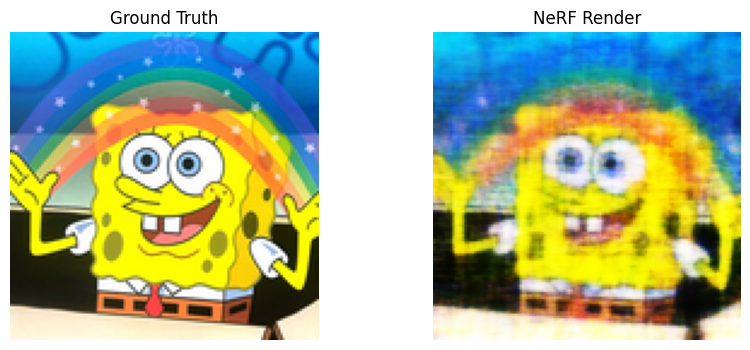

In [15]:
# Reshape the rendered image and display
rendered_image = rendered_rgb.detach().cpu().numpy().reshape(height, width, 3)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Ground Truth')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('NeRF Render')
plt.imshow(np.clip(rendered_image, 0, 1))
plt.axis('off')
plt.show()
# plt.subplot(1, 2, 3)
# plt.title('NeRF Render')
# plt.imshow(np.clip(rendered_image, 0, 1))
# plt.axis('off')
# plt.show()